# Introduction to SPHEREx Spectral Images

## 1. Learning Goals

- Query for SPHEREx Spectral Image Multi-Extension FITS files (MEFs) that overlap a given coordinate on the sky.
- Read in a SPHEREx Spectral Image MEF using Astropy and understand its structure.
- Interactively visualize a SPHEREx Spectral Image MEF using Firefly.
- Explore each extension. For the Spectral Image extension, this includes understanding the astrometric and spectral WCS systems.

## 2. SPHEREx Overview

SPHEREx is a NASA Astrophysics Medium Explorer mission that launched in March 2025. During its planned two-year mission, SPHEREx will obtain 0.75-5 micron spectroscopy over the entire sky, with deeper data in the SPHEREx Deep Fields. SPHEREx data will be used to:

* **constrain the physics of inflation** by measuring its imprints on the three-dimensional large-scale distribution of matter,
* **trace the history of galactic light production** through a deep multi-band measurement of large-scale clustering,
* **investigate the abundance and composition of water and biogenic ices** in the early phases of star and planetary disk formation.

The community will also mine SPHEREx data and combine it with synergistic data sets to address a variety of additional topics in astrophysics.

More information is available in the [SPHEREx Explanatory Supplement](https://irsa.ipac.caltech.edu/data/SPHEREx/docs/SPHEREx_Expsupp_QR_v1.0.pdf).

## 3. Requirements
The following packages must be installed to run this notebook. Comment out the following lines if they are already installed.

In [1]:
# !pip install numpy matplotlib astropy pyvo firefly-client

## 4. Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

import pyvo
from pyvo.dal.adhoc import DatalinkResults

from firefly_client import FireflyClient

## 5. Search for SPHEREx Spectral Image MEFs that overlap coordinates you are interested in

Define some coordinates of interest.

In [3]:
ra_deg = 304.693508808
dec_deg = 42.4436872991

Query IRSA for a list of Spectral Image MEFs that overlap this position.

In [4]:
# Define the TAP service URL for IRSA
tap_url = "https://irsa.ipac.caltech.edu/TAP"

# Connect to the TAP service
service = pyvo.dal.TAPService(tap_url)

# Define your ADQL query
query = "SELECT * FROM spherex.obscore WHERE CONTAINS(POINT('ICRS',"+str(ra_deg)+","+str(dec_deg)+"), s_region)=1"

# Submit the asynchronous query
job = service.submit_job(query)

# Run the job (starts the query execution on the server)
job.run()

# Wait for the job to complete (polling)
job.wait(phases=["COMPLETED", "ERROR", "ABORTED"], timeout=300)

# Capture the results
results = job.fetch_result()

Each row of the results of your query represents a different spectral image.
Because SPHEREx data will be released on a weekly basis, the number of rows returned will change
depending on when you submit the query.
Let's see how many images are returned today.

In [5]:
len(results)

162

The query results provide a lot of metadata about each spectral image. These columns have standard names as defined by the IVOA. Let's list them:

In [6]:
list(results.fieldnames)

['obs_id',
 's_ra',
 's_dec',
 'energy_bandpassname',
 'em_min',
 'em_max',
 't_min',
 't_max',
 't_exptime',
 'access_url',
 'access_format',
 'dataproduct_type',
 'calib_level',
 'target_name',
 'obs_title',
 'obs_collection',
 'facility_name',
 'instrument_name',
 'obs_creation_date',
 'obs_creator_name',
 'obs_release_date',
 'obs_publisher_did',
 'publisher_id',
 'bib_reference',
 'data_rights',
 's_fov',
 's_region',
 's_resolution',
 's_xel1',
 's_xel2',
 's_ucd',
 's_unit',
 's_resolution_min',
 's_resolution_max',
 's_calib_status',
 's_pixel_scale',
 't_xel',
 't_resolution',
 'em_xel',
 'em_calib_status',
 'em_res_power',
 'pol_xel',
 'proposal_id',
 'energy_emband',
 'position_timedependent',
 'obs_intent',
 'algorithm_name',
 'facility_keywords',
 'instrument_keywords',
 'environment_photometric',
 'proposal_project',
 'target_type',
 'target_standard',
 'target_moving',
 'target_keywords',
 'proposal_pi',
 'access_estsize',
 'o_ucd',
 'ipac_gid',
 'ipac_pub_date',
 'pt',


The 'access_url' column is particularly important because it tells you how to access the data. Let's look at the 'access_url' value for the first row:

In [7]:
results['access_url'][0]

'https://irsa.ipac.caltech.edu/datalink/links/spherex?ID=ivo://irsa.ipac/spherex_qr?2025W18_1B_0157_2/D1'

Examining this URL, it does not provide direct access to the SPHEREx spectral image. Rather, it returns a file that lists all the data products and services associated with this spectral image. For the SPHEREx Quick Release products, this includes:

(1) the primary product, a Spectral Image MEF ('semantics' column is #this); and

(2) a cutout service ('semantics' is #cutout).

Most users will be interested in the primary (#this) product. Here's how you get the URL to download it for the first row:

In [8]:
datalink_url = results['access_url'][0]
datalink_content = DatalinkResults.from_result_url(datalink_url)
spectral_image_url = next(datalink_content.bysemantics("#this")).access_url
spectral_image_url

'https://irsa.ipac.caltech.edu/ibe/data/spherex/qr/level2/2025W18_1B/l2b-v13-2025-198/1/level2_2025W18_1B_0157_2D1_spx_l2b-v13-2025-198.fits'

You can put this URL into a browser to download the file. Or you can work with it in Python, as shown below.

## 6. Examine the header of one of the SPHEREx Spectral Image MEFs

Use Astropy to examine the header of the URL from the previous step.

In [9]:
hdulist = fits.open(spectral_image_url)
hdulist.info()

Filename: /home/runner/.astropy/cache/download/url/5c32152b92f92a908f9cb89ff3983bcc/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  IMAGE         1 ImageHDU       217   (2040, 2040)   float32   
  2  FLAGS         1 ImageHDU       146   (2040, 2040)   int32   
  3  VARIANCE      1 ImageHDU       119   (2040, 2040)   float32   
  4  ZODI          1 ImageHDU       119   (2040, 2040)   float32   
  5  PSF           1 ImageHDU       509   (101, 101, 121)   float32   
  6  WCS-WAVE      1 BinTableHDU     18   1R x 3C   [7J, 7J, 98E]


You can see that the Level 2 Spectral Image files are multi-extension FITS files (MEFs) with the following extensions:

* **IMAGE:** Calibrated fluxes for a detector array in scientific units of MJy/sr.
* **FLAGS:** A bitmap with per-pixel status and processing flags.
* **VARIANCE:** A per-pixel estimate of the variance.
* **ZODI:** An model of the zodiacal dust background signal. Note that this is not subtracted from the IMAGE extension.
* **PSF:** An image cube (3D array) where each plane represents a Point Spread Function (PSF) for a cutout in over-sampled pixel space.
* **WCS-WAVE:** Spectral WCS lookup table that maps pixel coordinates to the central wavelength and bandwidth of each pixel.

We will tour each extension in the sections below.

## 7. Visualize a SPHEREx Spectral Image MEF using the Firefly Python Client.

We will use the open-source astronomy data visualization software Firefly visualize SPHEREx data. Firefly has a Python client and it understands the alternative WCS coordinates of SPHEREx, allowing users to see how the wavelength and bandwidth vary with spectral image pixels.

Open a Firefly viewer in a separate browser tab and initialize it.

In [10]:
fc = FireflyClient.make_client(url="https://irsa.ipac.caltech.edu/irsaviewer")

fc.reinit_viewer()

{'success': True}

Visualize a spectral image MEF by sending its URL to the viewer.

In [11]:
fc.show_fits(url=spectral_image_url,
             plot_id="spectral_image",
             Title="Spectral Image"
             )

{'success': True}

Try use the interactive tools in the viewer to explore the data.

## 8. Explore the first extension: IMAGE

The first extension of the MEF is the the calibrated surface brightness flux density in units of MJy/sr, stored as a 2040 x 2040 image. No zodiacal light subtraction is applied.

The SPHEREx focal plane is split with a dichroic to three short-wavelength and three long-wavelength detector arrays. Two focal plane assemblies (FPAs) simultaneously image the sky through a dichroic beam splitter. Each FPA contains three 2K x 2K detector arrays placed behind a set of linear variable filters (LVFs), providing narrow-band response with a band center that varies along one axis of the array. SPHEREx obtains spectra through multiple exposures, placing a given source at multiple positions in the field of view, where it is measured at multiple wavelengths by repointing the spacecraft.

* Band 1: λ= 0.75 - 1.09 µm; R=39
* Band 2: λ= 1.10 - 1.62 µm; R=41
* Band 3: λ= 1.63 - 2.41 µm; R=41
* Band 4: λ= 2.42 - 3.82 µm; R=35
* Band 5: λ= 3.83 - 4.41 µm; R=112
* Band 6: λ= 4.42 - 5.00 µm; R=128

Examine the header of the first extension, printing out select keywords.

In [12]:
spectral_image_header = hdulist[1].header

keywords_to_print = ['EXTNAME', 'NAXIS1', 'NAXIS2', 'BUNIT', 'DETECTOR', 'OBSID', 'DATE', 'PSF_FWHM']

for keyword in keywords_to_print:
    value = spectral_image_header.get(keyword, 'Keyword not found')
    print(f"{keyword}: {value}")

EXTNAME: IMAGE
NAXIS1: 2040
NAXIS2: 2040
BUNIT: MJy / sr
DETECTOR: 1
OBSID: 2025W18_1B_0157_2
DATE: 2025-07-17T20:28:57.406
PSF_FWHM: 5.029344163983229


We can see that this image was taken with Detector 2, so we can expect the wavelength to vary from 1.10 - 1.62 µm. Try examining the Firefly visualization to confirm this.

Notice that there is more than one WCS!

In [13]:
spectral_image_header['WCSNAME*']

WCSNAMEA= '0-based active pixel coordinates' / Coordinate system title          
WCSNAMEW= 'Approximated per-pixel wavelength and bandpass' / WCS label          

The main WCS describes the astrometric registration of the image, including optical distortion parameters, based on the FITS pixel convention starting with 1.

There are two alternative WCS systems:
- WCSNAMEA describes zero-based pixel coordinates.
- WCSNAMEW describes spectral coordinates 'Wavelength' and 'Bandpass'. This WCS contains a reference to the lookup table in the 'WCS-WAVE' extension.

### 8a. Spatial WCS

Load the Spatial WCS

In [14]:
wcs = WCS(spectral_image_header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 304.142120099 43.5289919506 
CRPIX : 1020.5 1020.5 
PC1_1 PC1_2  : -0.00159755470958 -0.000549937990661 
PC2_1 PC2_2  : -0.000611817559668 0.00161816418807 
CDELT : 1.0 1.0 
NAXIS : 2040  2040

Use standard Astropy methods to resolve the central ra and dec (given by crval1 and crval2 in the header) into image pixel coordinates.

In [15]:
ra, dec = wcs.wcs.crval
x, y = wcs.world_to_pixel(SkyCoord(ra=ra, dec=dec, unit="deg"))
print(ra, dec, x, y)

304.142120099 43.5289919506 1019.0039070141772 1020.8106768185589


### 8b. Spectral WCS

The use of Linear Variable Filters (LVFs) is a key component of SPHEREx imaging. Each pixel of the detector corresponds to a slightly different wavelength and bandwidth due to the LVF’s gradual variation in spectral transmission across its surface. Contours of constant wavelength are curved due to the method of filter fabrication, so the wavelength-vs-pixel function is inherently two-dimensional.

A compact, approximate representation of the wavelength and bandwidth per pixel is included in each image using the WAVE-TAB lookup-table mechanism defined in the FITS standard.

Below we illustrate how to use Spectral WCS to find an approximate wavelength at each pixel.

In [16]:
# Load the Spectral WCS from the header.
# Note that we need to provide a reference to HDU List, which contains a lookup table.
spectral_wcs = WCS(header=hdulist["IMAGE"].header, fobj=hdulist, key="W")

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


Note: The previous line triggers an Astropy INFO printout,
which implies that the SIP distortion coefficients from the main WCS are preserved in the alternative WCS.
This is because the SIP convention, not formally part of the FITS standard,
is ambiguous as to whether it is meant to apply to 'alternative' (lettered) WCSes in addition to the primary WCS.
See [astropy/astropy#13105](https://github.com/astropy/astropy/issues/13105).)

The wavelength per pixel is a property of the detector-filter combination and is independent of optical distortion in the telescope,
and is modeled accordingly in WCS 'W', so we turn the SIP distortion off for this WCS.

In [17]:
# SIP distortions must be turned off for the spectral WCS.
spectral_wcs.sip = None

In [18]:
# The standard Astropy methods for converting pixel coordinates to world coordinates can also be used to obtain spectral coordinates.
# Take the pixel coordinates that we determined for the image center and resolve them to the wavelength and bandpass for that pixel
wl, bp = spectral_wcs.pixel_to_world(x, y)
wl, bp

(<SpectralCoord 0.90461451 um>, <Quantity 0.02313592 um>)

### 8c. How does wavelength vary across the detector?

In [19]:
# Read in the spectral image data.
spectral_image = hdulist["IMAGE"]
spectral_image_data = spectral_image.data

# Get arrays of pixel coordinates for the image.
(y, x) = np.indices(spectral_image.shape)

# Use the spectral WCS to convert these pixel coordinates to spectral coordinates.
spectral_coords = spectral_wcs.pixel_to_world(x, y)

# Break out the two spectral coordinates (wavelength and bandpass) from the spectral coordinates, and print the results.
wavelength, bandpass = spectral_coords
print("Wavelength: \n", wavelength)
print("Bandpass: \n", bandpass)

Wavelength: 
 [[1.12631679 1.12629733 1.12627787 ... 1.126608   1.1266278  1.12664759]
 [1.12609689 1.12607743 1.12605798 ... 1.12638815 1.12640794 1.12642774]
 [1.125877   1.12585754 1.12583808 ... 1.1261683  1.12618809 1.12620788]
 ...
 [0.74555063 0.74553469 0.74551874 ... 0.7458939  0.74591023 0.74592655]
 [0.74539676 0.74538082 0.74536488 ... 0.74574004 0.74575636 0.74577269]
 [0.74524289 0.74522695 0.74521101 ... 0.74558618 0.7456025  0.74561882]] um
Bandpass: 
 [[0.02880606 0.02880556 0.02880506 ... 0.0288135  0.02881401 0.02881452]
 [0.02880043 0.02879994 0.02879944 ... 0.02880788 0.02880839 0.02880889]
 [0.02879481 0.02879431 0.02879381 ... 0.02880226 0.02880276 0.02880327]
 ...
 [0.01906779 0.01906738 0.01906698 ... 0.01907657 0.01907699 0.01907741]
 [0.01906386 0.01906345 0.01906304 ... 0.01907264 0.01907305 0.01907347]
 [0.01905992 0.01905951 0.01905911 ... 0.0190687  0.01906912 0.01906954]] um


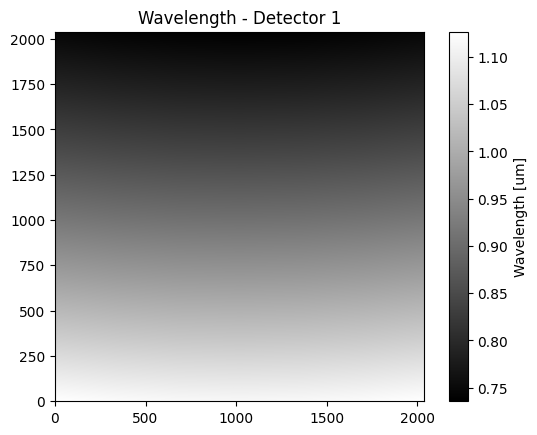

In [20]:
# Plot the wavelength as a greyscale color map across the image pixels.
plt.imshow(wavelength.value, origin='lower', cmap='gray')
plt.colorbar(label=f"Wavelength [{wavelength.unit}]")

detector = hdulist["IMAGE"].header["DETECTOR"]
plt.title(f"Wavelength - Detector {detector}")
plt.show()

As expected, the wavelengths range from approximately 1.1=16 micron for Detector 2. You can see that the longest wavelengths are at the bottom and the shortest wavelengths are at the top. You can verify this is the case in the Firefly visualization, as well.

### 8d. Number of flagged pixels in this image

Now let's take a look at some header keywords that provide information about how many pixels have been flagged during processing.

In [21]:
spectral_image_header['L2 N_*']

HIERARCH L2 N_NONLINEAR = 0 / number of pixels flagged nonlinear                
HIERARCH L2 N_PERSIST = 18614 / number of pixels flagged persist                
HIERARCH L2 N_HOT =                    2 / number of pixels flagged hot         
HIERARCH L2 N_COLD = 1402 / number of pixels flagged cold                       
HIERARCH L2 N_SOURCE = 3730054 / number of source flagged pixels                
HIERARCH L2 N_OUTLIER = 23451 / number of flagged outlier pixels                
HIERARCH L2 N_TRANSIENT = 52193 / number of flagged transient pixels            
HIERARCH L2 N_OVERFLOW = 2069 / number of flagged overflow pixels               
HIERARCH L2 N_SUR_ERROR = 29599 / number of flagged sur error pixels            
HIERARCH L2 N_NONFUNC = 1898 / number of flagged nonfunctional pixels           
HIERARCH L2 N_DICHROIC = 0 / number of flagged pixels due to low efficiency of d
HIERARCH L2 N_MISSING = 0 / number of flagged pixels with missing data          
HIERARCH L2 N_FULLSAMPLE = 2

There are 14 flags in total. Typically, most of the pixels are identified as SOURCE pixels, which are pixels mapped to a known source. The remaining flags are described in Table 8 of the [SPHEREx Explanatory Supplement](https://irsa.ipac.caltech.edu/data/SPHEREx/docs/spherex_explanatory_supplement.pdf).

## 9. Explore the second extension: FLAGS

The second extension (FLAGS) provides a bitmap of per-pixel status and processing flags, stored as a 2040 x 2040 image.

Let's take a look at the header of the FLAGS extension, and print out some header keywords of interest.

In [22]:
flags_header = hdulist[2].header

keywords_to_print = ['EXTNAME', 'NAXIS1', 'NAXIS2', 'BUNIT']

for keyword in keywords_to_print:
    value = flags_header.get(keyword, 'Keyword not found')
    print(f"{keyword}: {value}")

EXTNAME: FLAGS
NAXIS1: 2040
NAXIS2: 2040
BUNIT:


Conveniently, the definitions of the flags are also provided in the FLAGS header.

In [23]:
flags_header['MP*']

HIERARCH MP_TRANSIENT = 0 / Transient detected during SUR                       
HIERARCH MP_OVERFLOW = 1 / Overflow detected during SUR                         
HIERARCH MP_SUR_ERROR = 2 / Error in onboard processing                         
HIERARCH MP_PHANTOM = 4 / Phantom pixel                                         
HIERARCH MP_REFERENCE = 5 / Reference pixel                                     
HIERARCH MP_NONFUNC = 6 / Permanently unusable                                  
HIERARCH MP_DICHROIC = 7 / Low efficiency due to dichroic                       
HIERARCH MP_MISSING_DATA = 9 / Onboard data lost                                
MP_HOT  =                   10 / Hot pixel                                      
MP_COLD =                   11 / Anomalously low signal                         
HIERARCH MP_FULLSAMPLE = 12 / Pixel full sample history is available            
HIERARCH MP_PHANMISS = 14 / Phantom correction was not applied                  
HIERARCH MP_NONLINEAR = 15 /

Tip: In the Firefly visualization, if you are looking at the first extension (IMAGE), you can open up the layers icon (top right) to enable overlaying a visualization of the flags.

## 10. Explore the third extension: VARIANCE

The third extension of the MEF is the variance of the calibrated surface brightness flux in units of (MJy/sr)^2, stored as a 2,040 x 2,040 image. Let's look at some specific header keywords:

In [24]:
variance_header = hdulist[3].header

keywords_to_print = ['EXTNAME', 'NAXIS1', 'NAXIS2', 'BUNIT']

for keyword in keywords_to_print:
    value = variance_header.get(keyword, 'Keyword not found')
    print(f"{keyword}: {value}")

EXTNAME: VARIANCE
NAXIS1: 2040
NAXIS2: 2040
BUNIT: MJy2 / sr2


## 11. Explore the fourth extension: ZODI

The fourth extension of the MEF is the modeled zodiacal light background flux in units of MJy/sr, stored as a 2040 x 2040 image. This has not been subtracted from the IMAGE extension. Let's examine some header keywords:

In [25]:
zodi_header = hdulist[4].header

keywords_to_print = ['EXTNAME', 'NAXIS1', 'NAXIS2', 'BUNIT']

for keyword in keywords_to_print:
    value = zodi_header.get(keyword, 'Keyword not found')
    print(f"{keyword}: {value}")

EXTNAME: ZODI
NAXIS1: 2040
NAXIS2: 2040
BUNIT: MJy / sr


## 12. Explore the fifth extension: PSF

The fifth extension of the MEF contains 121 Point-spread functions (PSFs); each PSF is represented as a 101 x 101 image and all 121 are assembled together into a cube. Each of the 121 layers represents a "super-resolution" PSF estimate in a different region (defined by an 11x11 grid) of the detector. Each PSF is a two-dimensional array with size of 101 × 101 pixels. The PSFs are oversampled such that 10 PSF pixels cover the same spatial extent as one spectral image pixel (0.615 arcsec). Let's look at some specific header keywords for the PSF:

In [26]:
psf_header = hdulist[5].header

keywords_to_print = ['EXTNAME', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'BUNIT']

for keyword in keywords_to_print:
    value = psf_header.get(keyword, 'Keyword not found')
    print(f"{keyword}: {value}")

EXTNAME: PSF
NAXIS1: 101
NAXIS2: 101
NAXIS3: 121
BUNIT:


## 13. Explore the sixth extension: WCS-WAVE

The sixth extension is a FITS-compliant spectral World Coordinate System (WCS) lookup table that maps spectral image pixel coordinates to central wavelengths and bandwidths. The lookup table consists of 1 row with 3 columns (X, Y, VALUES). X and Y are each arrays defining a grid of control points in spectral image pixel space. For each (X, Y) control point, VALUES defines a two-element array containing the central wavelength and the corresponding bandwidth. Originally adopted to support the unique nature of the SPHEREx LVF filters, this rarely-used part of the FITS standard has yet to be implemented by all readers. The Firefly client we use in this notebook does correctly interpret this lookup table.

Let's look at the header of the WCS-WAVE extension:

In [27]:
wcs_wave_header = hdulist[6].header
wcs_wave_header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  448 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
EXTNAME = 'WCS-WAVE'                                                            
TTYPE1  = 'X       '                                                            
TFORM1  = '7J      '                                                            
TDIM1   = '(7)     '                                                            
TTYPE2  = 'Y       '        

Unlike the other extensions, this is a binary table. Let's read it iinto an Astropy table.

In [28]:
wcs_wave_table = Table(hdulist[6].data)

print("Number of rows:", len(wcs_wave_table))
print("Column names:", wcs_wave_table.colnames)

Number of rows: 1
Column names: ['X', 'Y', 'VALUES']


This table consists of just 1 row with three columns. Let's inspect the columns:

In [29]:
x_array      = wcs_wave_table["X"][0]
y_array      = wcs_wave_table["Y"][0]
wavelengths  = wcs_wave_table["VALUES"][0]

print("X:",  x_array)
print("Y:",y_array)
print("Dimensions of VALUES array:",  wavelengths.shape)

X: [   1  341  681 1021 1361 1701 2040]
Y: [   1  341  681 1021 1361 1701 2040]
Dimensions of VALUES array: (7, 7, 2)


## Acknowledgements

- [IPAC-IRSA](https://irsa.ipac.caltech.edu/)

## About this notebook

**Authors:** IPAC Science Platform Team, including Jessica Krick, Troy Raen, Brigitta Sipőcz, Jaladh Singhal,
Andreas Faisst, Shoubaneh Hemmati, Vandana Desai

**Contact:** [IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions
or problems.

**Updated:** June 2025

**Runtime:** approximately 30 seconds